In [1]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

In [2]:
# -----------------------------
# 1. Configuration
# -----------------------------
SELECTED_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car']
CLASS_TO_INDEX = {cls: idx for idx, cls in enumerate(SELECTED_CLASSES)}

ANNOTATIONS_DIR = r"C:\Users\muham\Downloads\archive (2)\VOC2012\Annotations"
IMAGES_DIR = r"C:\Users\muham\Downloads\archive (2)\VOC2012\JPEGImages"
IMG_SIZE = (224, 224)
NUM_CLASSES = len(SELECTED_CLASSES)
BATCH_SIZE = 8

In [3]:
# -----------------------------
# 2. Parse annotations
# -----------------------------
def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        cls = obj.find('name').text
        if cls not in SELECTED_CLASSES:
            continue
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        objects.append({'class': cls, 'bbox': [xmin, ymin, xmax, ymax], 'filename': root.find('filename').text})
    return objects
    
def load_annotations(annotations_dir, images_dir):
    image_paths, labels, bboxes = [], [], []
    for xml_file in os.listdir(annotations_dir):
        if not xml_file.endswith('.xml'):
            continue
        full_xml_path = os.path.join(annotations_dir, xml_file)
        objects = parse_voc_annotation(full_xml_path)
        for obj in objects:
            img_path = os.path.join(images_dir, obj['filename'])
            if os.path.exists(img_path):
                image_paths.append(img_path)
                labels.append(CLASS_TO_INDEX[obj['class']])
                bboxes.append(obj['bbox'])
    return image_paths, labels, bboxes

In [6]:
# -----------------------------
# 3. Data Generator
# -----------------------------
class PascalVOCGenerator(Sequence):
    def __init__(self, image_paths, labels, bboxes, batch_size=8, img_size=(224, 224), num_classes=7):
        self.image_paths = image_paths
        self.labels = labels
        self.bboxes = bboxes
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_class = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_bbox = self.bboxes[idx * self.batch_size:(idx + 1) * self.batch_size]

        images, class_labels, bbox_labels = [], [], []
        for i, img_path in enumerate(batch_x):
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            images.append(img)

            label = batch_y_class[i]
            one_hot = np.zeros(self.num_classes)
            one_hot[label] = 1
            class_labels.append(one_hot)

            bbox = batch_y_bbox[i]
            width, height = self.img_size
            bbox = [bbox[0]/width, bbox[1]/height, bbox[2]/width, bbox[3]/height]
            bbox_labels.append(bbox)

        return np.array(images), {
            'class_output': np.array(class_labels),
            'bbox_output': np.array(bbox_labels)
        }

In [7]:
# -----------------------------
# 4. Load dataset
# -----------------------------
image_paths, labels, bboxes = load_annotations(ANNOTATIONS_DIR, IMAGES_DIR)
train_paths, val_paths, train_labels, val_labels, train_bboxes, val_bboxes = train_test_split(
    image_paths, labels, bboxes, test_size=0.2, random_state=42
)

train_generator = PascalVOCGenerator(train_paths, train_labels, train_bboxes, batch_size=BATCH_SIZE)
val_generator = PascalVOCGenerator(val_paths, val_labels, val_bboxes, batch_size=BATCH_SIZE)

print("Training batches:", len(train_generator))
print("Validation batches:", len(val_generator))

Training batches: 891
Validation batches: 223


In [2]:
# -----------------------------
# 5. Build MobileNetV2 Model
# -----------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

class_output = Dense(NUM_CLASSES, activation='softmax', name='class_output')(x)
bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)

model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mean_squared_error'},
    metrics={'class_output': 'accuracy', 'bbox_output': 'mse'}
)

model.summary()

NameError: name 'MobileNetV2' is not defined

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save best model as HDF5 format
checkpoint_cb = ModelCheckpoint(
    filepath="voc_mobilenet_best_model.h5",  # Use .h5 to avoid native Keras options issue
    monitor='val_class_output_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_class_output_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb]
)

print("✅ Training completed. Best model saved as voc_mobilenet_best_model.h5")

Epoch 1/20
891/891 [==============================] - ETA: 0s - loss: 0.9164 - class_output_loss: 0.5782 - bbox_output_loss: 0.3381 - class_output_accuracy: 0.8090 - bbox_output_mse: 0.3381
Epoch 1: val_class_output_accuracy improved from -inf to 0.84063, saving model to voc_mobilenet_best_model.h5


C:\Users\muham\anaconda3\envs\tfenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


891/891 [==============================] - 207s 232ms/step - loss: 0.9164 - class_output_loss: 0.5782 - bbox_output_loss: 0.3381 - class_output_accuracy: 0.8090 - bbox_output_mse: 0.3381 - val_loss: 0.8077 - val_class_output_loss: 0.4925 - val_bbox_output_loss: 0.3152 - val_class_output_accuracy: 0.8406 - val_bbox_output_mse: 0.3152
Epoch 2/20
891/891 [==============================] - ETA: 0s - loss: 0.8171 - class_output_loss: 0.4863 - bbox_output_loss: 0.3308 - class_output_accuracy: 0.8397 - bbox_output_mse: 0.3308
Epoch 2: val_class_output_accuracy improved from 0.84063 to 0.84680, saving model to voc_mobilenet_best_model.h5
891/891 [==============================] - 215s 241ms/step - loss: 0.8171 - class_output_loss: 0.4863 - bbox_output_loss: 0.3308 - class_output_accuracy: 0.8397 - bbox_output_mse: 0.3308 - val_loss: 0.7766 - val_class_output_loss: 0.4653 - val_bbox_output_loss: 0.3114 - val_class_output_accuracy: 0.8468 - val_bbox_output_mse: 0.3114
Epoch 3/20
891/891 [=======

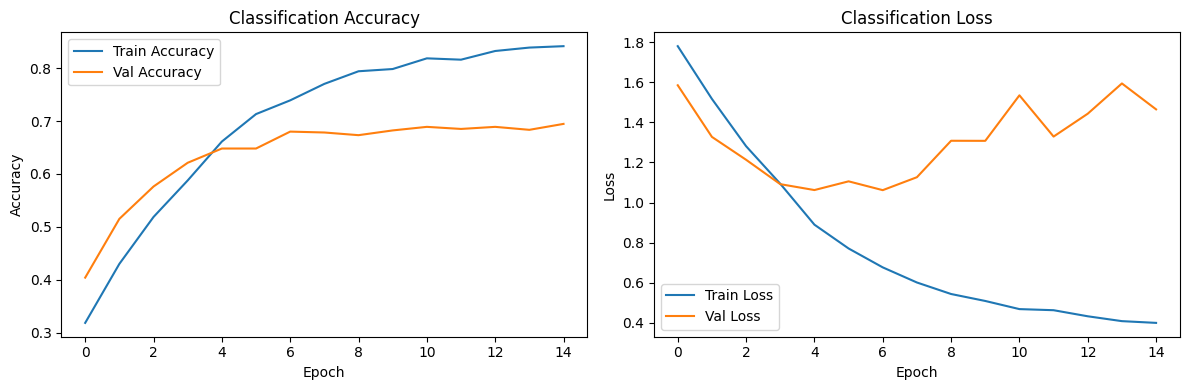

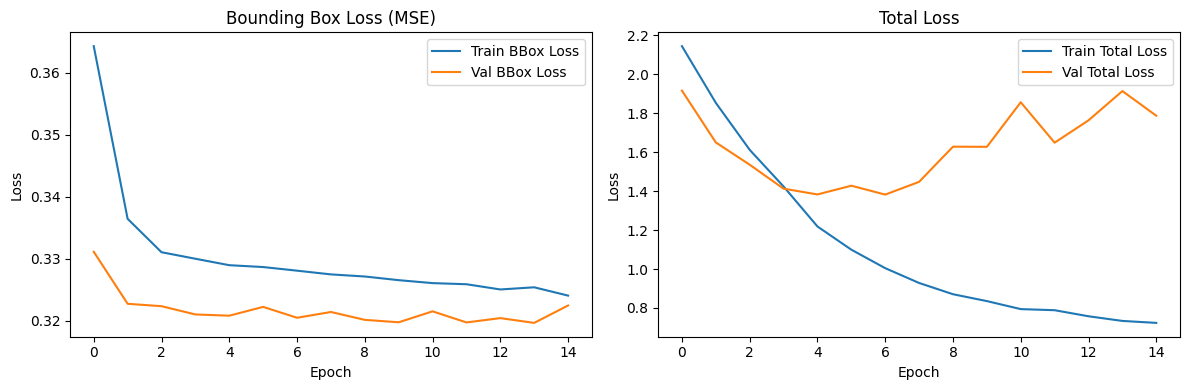

In [11]:
import pickle
import matplotlib.pyplot as plt

# Load saved history
with open('training_history.pkl', 'rb') as f:
    history_data = pickle.load(f)

# Classification Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_data['class_output_accuracy'], label='Train Accuracy')
plt.plot(history_data['val_class_output_accuracy'], label='Val Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Classification Loss
plt.subplot(1, 2, 2)
plt.plot(history_data['class_output_loss'], label='Train Loss')
plt.plot(history_data['val_class_output_loss'], label='Val Loss')
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Bounding Box Loss and Total Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_data['bbox_output_loss'], label='Train BBox Loss')
plt.plot(history_data['val_bbox_output_loss'], label='Val BBox Loss')
plt.title('Bounding Box Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_data['loss'], label='Train Total Loss')
plt.plot(history_data['val_loss'], label='Val Total Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import numpy as np
import pyttsx3
from tensorflow.keras.models import load_model

# ----------------------------
# Load the best saved model
# ----------------------------
model = load_model("voc_mobilenet_best_model.h5")

# Class names for Pascal VOC (7 classes)
CLASS_NAMES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car']

# Initialize speech engine
engine = pyttsx3.init()
engine.setProperty('rate', 150)

# Confidence threshold
THRESHOLD = 0.5
last_spoken_label = None

# ----------------------------
# Prediction function
# ----------------------------
def predict_frame(frame):
    orig = frame.copy()
    h, w = frame.shape[:2]

    # Preprocess for MobileNet
    img = cv2.resize(frame, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict with two outputs
    class_probs, bbox = model.predict(img)
    class_probs = class_probs[0]
    bbox = bbox[0]

    class_idx = np.argmax(class_probs)
    label = CLASS_NAMES[class_idx]
    confidence = class_probs[class_idx]

    # Rescale bbox
    scale_x = w / 224
    scale_y = h / 224
    xmin = int(bbox[0] * 224 * scale_x)
    ymin = int(bbox[1] * 224 * scale_y)
    xmax = int(bbox[2] * 224 * scale_x)
    ymax = int(bbox[3] * 224 * scale_y)

    # Draw bounding box
    if confidence >= THRESHOLD:
        cv2.rectangle(orig, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(orig, f"{label} ({confidence:.2f})", (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    else:
        label = "No confident detection"

    return orig, label, confidence

# ----------------------------
# Speak detected object
# ----------------------------
def speak_label(label, confidence):
    global last_spoken_label
    if label != last_spoken_label and confidence >= THRESHOLD and label != "No confident detection":
        engine.say(f"{label} detected")
        engine.runAndWait()
        last_spoken_label = label

# ----------------------------
# GUI setup
# ----------------------------
root = tk.Tk()
root.title("Blind Assistant Navigator - Real-time Detection")
root.geometry("900x700")

image_label = tk.Label(root)
image_label.pack()

cap = None
running_webcam = False

# ----------------------------
# Browse image
# ----------------------------
def browse_image():
    global last_spoken_label
    last_spoken_label = None
    path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
    if path:
        frame = cv2.imread(path)
        if frame is None:
            messagebox.showerror("Error", "Unable to read the selected image.")
            return

        result_frame, label, conf = predict_frame(frame)
        speak_label(label, conf)

        rgb = cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(rgb)
        imgtk = ImageTk.PhotoImage(image=img)

        image_label.imgtk = imgtk
        image_label.configure(image=imgtk)

# ----------------------------
# Webcam prediction
# ----------------------------
def start_webcam():
    global cap, running_webcam, last_spoken_label
    cap = cv2.VideoCapture(0)
    running_webcam = True
    last_spoken_label = None
    update_webcam_frame()

def stop_webcam():
    global running_webcam
    running_webcam = False
    if cap:
        cap.release()

def update_webcam_frame():
    global cap, running_webcam
    if running_webcam and cap.isOpened():
        ret, frame = cap.read()
        if ret:
            result_frame, label, conf = predict_frame(frame)
            speak_label(label, conf)

            rgb = cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(rgb)
            imgtk = ImageTk.PhotoImage(image=img)

            image_label.imgtk = imgtk
            image_label.configure(image=imgtk)

        root.after(1000, update_webcam_frame)  # Predict every second

# ----------------------------
# Buttons
# ----------------------------
btn_frame = tk.Frame(root)
btn_frame.pack(pady=20)

tk.Button(btn_frame, text="Browse Image", command=browse_image, width=20).pack(side=tk.LEFT, padx=10)
tk.Button(btn_frame, text="Exit", command=root.destroy, width=20).pack(side=tk.LEFT, padx=10)

root.mainloop()

1/1 [==============================] - 1s 716ms/step
